In [2]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import torch
import copy
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

## Dataset 2: Telco Customer Churn
https://www.kaggle.com/blastchar/telco-customer-churn

Algorithms to investigate:
1. Decision trees with some form of pruning
2. Neural networks
3. Boosting
4. Support Vector Machines
5. k-nearest neighbors

In [10]:
# Read data in
df = pd.read_csv('./data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df_orig = df.copy()

# Change columns
df['tenure'] = pd.to_numeric(df['tenure'])
df = df.drop(['customerID'], axis=1)
df['MonthlyCharges'] = df['MonthlyCharges'].map(lambda x: float(x))
df['MonthlyCharges'] = pd.to_numeric(df['MonthlyCharges'])
df['TotalCharges'] = df['TotalCharges'].map(lambda x: float(x) if x!=' ' else -9999)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])

# Feature engineering columns
"""
· “Long Term Bundle Client” = if( “tenure” > 24 months && “InternetService” != No && “PhoneService” == Yes), (Yes or No)
· “Bachelor Client” = if( “gender” == male && “Partner” == No && “Dependents” == No), (Yes or No)
· “New Family Client” = if( “Partner” == Yes && “Dependents” == Yes && “tenure” < 12 months), (Yes or No)
"""
df['Long Term Bundle Client'] = (df["tenure"]>24) & (df['InternetService']!='No') & (df['PhoneService']=='Yes')
df['Bachelor Client'] = (df['gender']=='Male') & (df['Partner']=='No') & (df['Dependents']=='No')
df['New Family Client'] = (df['Partner']=='Yes') & (df['Dependents']=='Yes') & (df['tenure']<12)
for col in ['Long Term Bundle Client', 'Bachelor Client', 'New Family Client']:
    df[col] = df[col].apply(lambda x: 1 if x else 0)

# Get dummies based on prev. dataframe
df = df.drop(['Churn'], axis=1)
df = pd.get_dummies(df)

df_orig['Churn'] = df_orig['Churn'].map({'No':0,'Yes':1})
pd.set_option('display.max_columns', 500)
df.values[0:1]

X = df.values
y = df_orig['Churn'].values
X.shape, y.shape

((7043, 48), (7043,))

In [11]:
X = df.values[:,:-2]
y = df.values[:,-1]
print("Number of positive samples: ", (y==1).sum())
print("Number of positive samples: ", (y==0).sum())
print("y shape: ", y.shape)
print("X shape: ", X.shape)

Number of positive samples:  1612
Number of positive samples:  5431
y shape:  (7043,)
X shape:  (7043, 46)


In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)
y_train.sum(), y_test.sum()

(1300.0, 312.0)

In [92]:
scaler = StandardScaler()
scaler.fit(X_train)
scaler.mean_
X_train = scaler.transform(X_train)
X_train.shape, X_train

((5634, 46),
 array([[-0.44119892, -0.94328209, -1.3273276 , ...,  0.82753164,
         -0.52710604, -0.53150247],
        [-0.44119892,  1.61999733, -0.00253038, ...,  0.82753164,
         -0.52710604, -0.53150247],
        [-0.44119892, -1.26877789, -0.30248447, ..., -1.20841301,
         -0.52710604, -0.53150247],
        ...,
        [-0.44119892,  1.21312758,  1.37559201, ...,  0.82753164,
         -0.52710604,  1.88145879],
        [-0.44119892,  0.48076203,  0.20577107, ...,  0.82753164,
         -0.52710604, -0.53150247],
        [-0.44119892, -1.26877789, -1.4856367 , ..., -1.20841301,
         -0.52710604, -0.53150247]]))

In [93]:
scaler = StandardScaler()
scaler.fit(X_test)
X_test = scaler.transform(X_test)

### 1.1 Decision Tree with some form of pruning

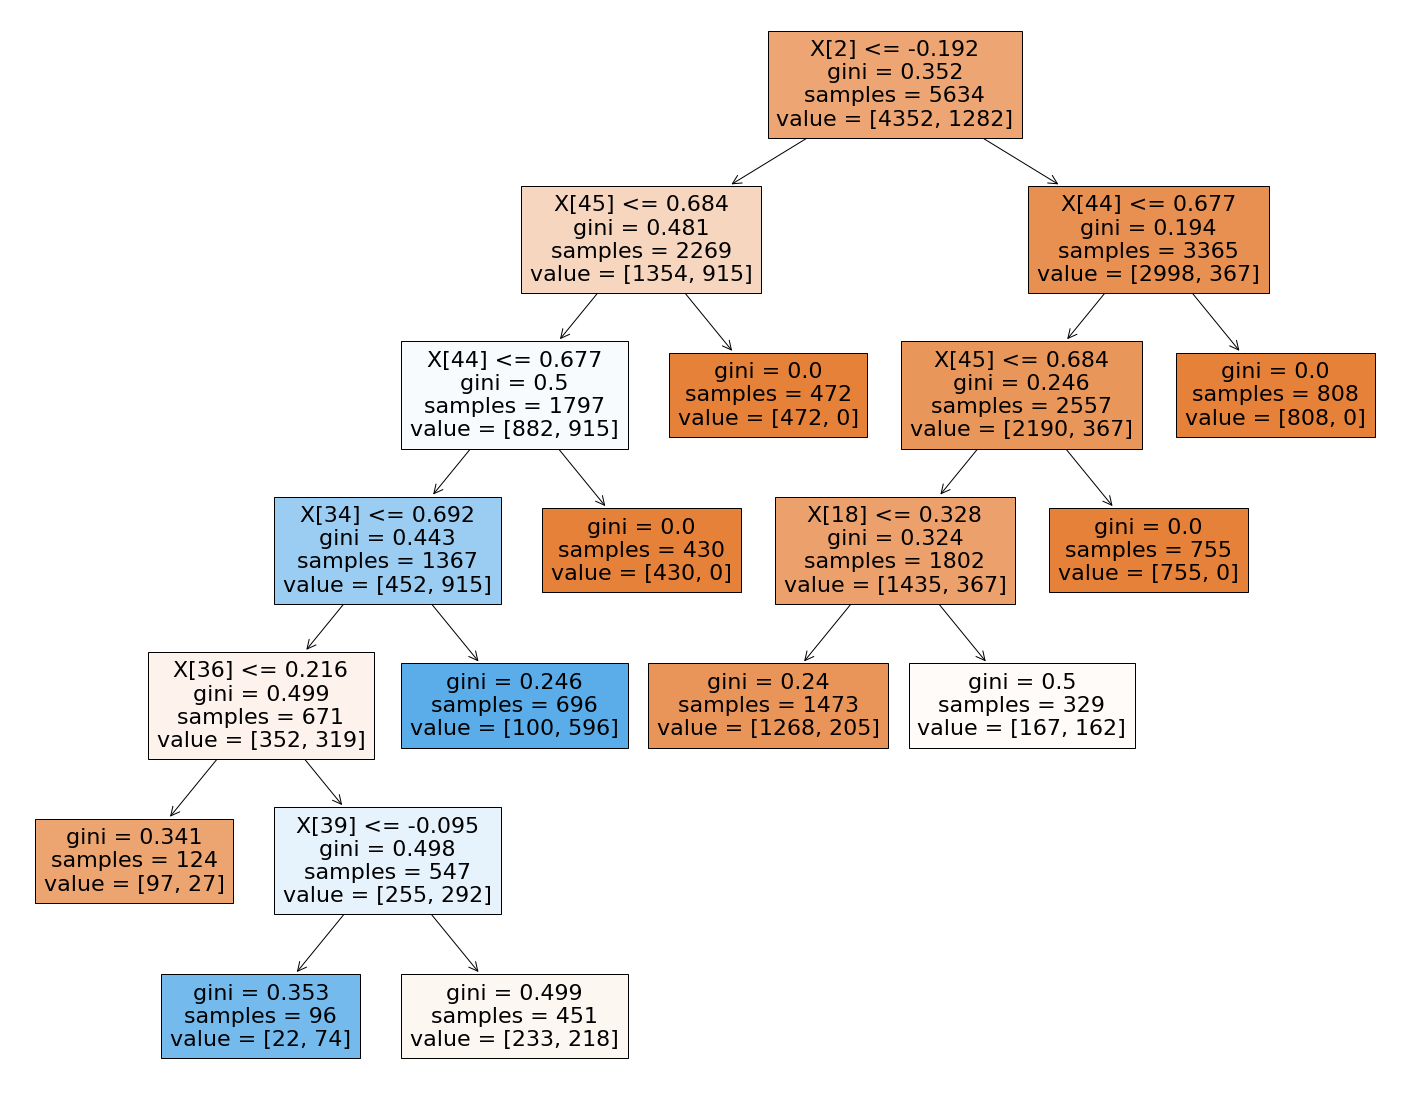

In [16]:
clf = DecisionTreeClassifier(random_state=0, max_leaf_nodes=10)
clf.fit(X_train, y_train)
plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, filled=True)
plt.show()

[Text(0.5, 0, 'Depth of Tree'), Text(0, 0.5, 'AUC')]

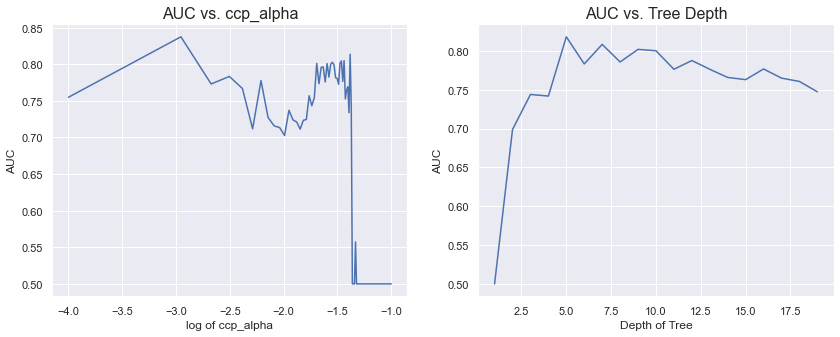

In [19]:
sns.set_theme()


n = 5

ccp_alphas = np.linspace(0.0001, 0.1, 100)
scores = []
for ccp_alpha in ccp_alphas:
    avg = 0
    for i in range(n):
        X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2)
        clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
        clf.fit(X_tr, y_tr)
        avg += roc_auc_score(y_val, clf.predict(X_val))
    avg /= n
    scores.append(avg)

f, ax = plt.subplots(1,2, figsize=(14, 5))
sns.lineplot(x=np.log10(np.array(ccp_alphas)), y=np.array(scores), ax=ax[0])
ax[0].set_title("AUC vs. ccp_alpha", fontsize=16)
ax[0].set(xlabel='log of ccp_alpha', ylabel='AUC')


opts = range(1,20)
scores = []
for opt in opts:
    avg = 0
    for i in range(n):
        X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2)
        clf = DecisionTreeClassifier(random_state=0, max_depth=opt)
        clf.fit(X_tr, y_tr)
        avg += roc_auc_score(y_val, clf.predict(X_val))
    avg /= n
    scores.append(avg)
        

sns.lineplot(x=np.array(opts), y=np.array(scores), markers=True, ax=ax[1])
ax[1].set_title("AUC vs. Tree Depth", fontsize=16)
ax[1].set(xlabel='Depth of Tree', ylabel='AUC')

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:44<00:00,  1.13it/s]


[Text(0.5, 0, 'Log2(Dataset Size)'), Text(0, 0.5, 'AUC')]

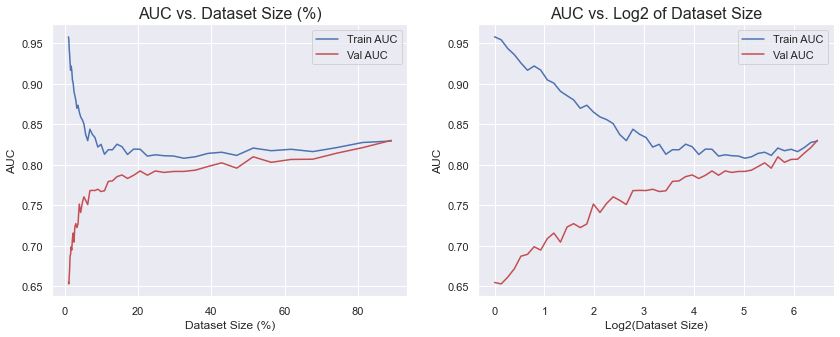

In [21]:
train_szs = np.logspace(-2, -0.05, 50) #np.linspace(0.01, 0.9, 50)
n = 100
scores_tr = []
scores_val = []
for train_sz in tqdm(train_szs):
    avg_score_tr = 0
    avg_score_val = 0
    worked = 0
    for i in range(n):
        X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train, test_size=1-train_sz)
        if (y_train1.sum()==0) or (y_test1.sum()==0) or ((y_train1==0).sum()==0) or ((y_test1==0).sum()==0): continue
        clf = DecisionTreeClassifier(random_state=0, max_depth=5)
        clf.fit(X_train1, y_train1)
        score = roc_auc_score(y_test1, clf.predict(X_test1))
        avg_score_val += score
        score = roc_auc_score(y_train1, clf.predict(X_train1))
        avg_score_tr += score
        worked += 1
    avg_score_tr /= worked
    avg_score_val /= worked
    scores_tr.append(avg_score_tr)
    scores_val.append(avg_score_val)

f, ax = plt.subplots(1,2, figsize=(14, 5))

ax[0].plot(np.array(train_szs)*100, scores_tr, '-', color="b", label="Train AUC")
ax[0].plot(np.array(train_szs)*100, scores_val, '-', color="r", label="Val AUC")
ax[0].legend()
ax[0].set_title("AUC vs. Dataset Size (%)", fontsize=16)
ax[0].set(xlabel='Dataset Size (%)', ylabel='AUC')

ax[1].plot(np.log2(np.array(train_szs)*100), scores_tr, '-', color="b", label="Train AUC")
ax[1].plot(np.log2(np.array(train_szs)*100), scores_val, '-', color="r", label="Val AUC")
ax[1].legend()
ax[1].set_title("AUC vs. Log2 of Dataset Size", fontsize=16)
ax[1].set(xlabel='Log2(Dataset Size)', ylabel='AUC')


# sns.scatterplot(x='Train Size (%)', y='AUC', \
#            data=pd.DataFrame({'Train Size (%)':np.array(train_szs)*100, 'AUC':np.array(scores)}))

In [97]:
# Finding final train and test scores
from time import time
tic = time()
clf = DecisionTreeClassifier(random_state=0, max_depth=5)
clf.fit(X_train, y_train)
print("Time was {}".format(time()-tic))
y_pred_tr = clf.predict(X_train)
y_pred_val = clf.predict(X_test)
print("Test: ", roc_auc_score(y_test, y_pred_val))
print("Train: ", roc_auc_score(y_train, y_pred_tr))

Time was 0.017950773239135742
Test:  0.8294649744057219
Train:  0.8299298924425828


### 1.2 Neural Network

In [76]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        minority_mask = y == 1
        minority_idxs = np.argwhere(minority_mask)[:,0]
        minority_idxs_sampled = np.random.choice(minority_idxs, size=int(y.shape[0]/3), replace=True)
        self.X = np.concatenate([X, X[minority_idxs_sampled]])
        self.y = np.concatenate([y, y[minority_idxs_sampled]]).reshape((-1,1))
        print("# of positive examples: {}, # of negative examples: {}".format((self.y==1).sum(),(self.y==0).sum()))
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]).float(), torch.squeeze(torch.from_numpy(self.y[idx]).long(), 0)

class MiniNet(torch.nn.Module):
    def __init__(self, h):
        super(MiniNet, self).__init__()
        hidden = h
        self.fc1 = torch.nn.Linear(46, hidden)
        self.relu = torch.nn.ReLU()

        self.drop = torch.nn.Dropout(0.2)
        self.fc2 = torch.nn.Linear(hidden, 2)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.fc2(x)
        return x
    
    

In [74]:
def training_loop(h, lr, X_tr, X_val, y_tr, y_val, use_early_stopping=True):
#     print("Running training with h: {} and lr: {}".format(h, lr))
    net = MiniNet(h)
    net = net.train()
    
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    batch_size = 64
    early = 10
    auc_avg = 0
    epochs = 300
    best_net = copy.deepcopy(net)
    verbose_train = False

    dataset_train = MyDataset(X_tr, y_tr)

    best = 0
    aucs = []

    for j, epoch in tqdm(enumerate(range(epochs))):
        loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=8, shuffle=True)
        net = net.train()
        for i, (X_batch, y_batch) in enumerate(iter(loader_train)):
            optimizer.zero_grad()
            output = net(X_batch)
            
            loss = criterion(output, y_batch)
            # Changing loss weighting
            # weights = torch.ones(loss.size())
            # weightsLarge = torch.ones(loss.size()) * 10000
            # weights = torch.where(y_batch==0, weights, weightsLarge)
            # loss = weights * loss
            loss = loss.mean()
            
            loss.backward()
            optimizer.step()
            
        # Run on training
        net = net.eval()
        outputs = net(torch.from_numpy(X_tr).float())
        yhat = torch.nn.functional.softmax(outputs, dim=1)[:,1]
        auc_tr = roc_auc_score(y_tr, yhat.detach())

        # Run on validation
        net = net.eval()
        outputs = net(torch.from_numpy(X_val).float())
        yhat = torch.nn.functional.softmax(outputs, dim=1)[:,1]
        auc = roc_auc_score(y_val, yhat.detach())

        if use_early_stopping:
            if auc > best:
                best = auc
                early_cnt = 0
                best_net = copy.deepcopy(net)
            elif early_cnt >= early:
                if verbose_train: print("Early Stopping, best AUC was {}".format(best))
                auc_avg+=best
                break
            else:
                early_cnt += 1

        # Check if end
        if epoch==epochs-1:
            if verbose_train: print("Finished epochs, best AUC was {}".format(best))
            auc_avg+=best
            break
            
        aucs.append([j, auc_tr, auc])

        if verbose_train: print("Batch {}, Validation AUC: {}".format(epoch, auc))
    return best_net, aucs

# Predict on val set
from sklearn.metrics import accuracy_score
def evaluate(net, X_test, y_test):
    net = net.eval()
    outputs = net(torch.from_numpy(X_test).float())
    yhat = torch.nn.functional.softmax(outputs, dim=1)[:,1]
    yhat = yhat.detach().numpy()
    auc = roc_auc_score(y_test, yhat)
    t = 0.5
    yhat[yhat>t] = 1
    yhat[yhat<=t] = 0
    return auc, accuracy_score(y_test, yhat)

In [34]:
hs = [10,80,320]
f1s0 = []
aucs0 = []
accs0 = []
n_folds = 5
n_loops = 1

skf = StratifiedKFold(n_splits=n_folds)

for h in hs:
    avg_auc = 0
    avg_acc = 0
    for i in range(n_loops):
        for train_index, test_index in skf.split(X_train, y_train):
            print("new training")
            X_tr, X_val = X[train_index], X[test_index]
            y_tr, y_val = y[train_index], y[test_index]
            data = [X_tr, X_val, y_tr, y_val]
            net, aucs = training_loop(h, 0.001, *data)
            auc, acc = evaluate(net, X_test=X_val, y_test=y_val)
            print(auc)
            avg_auc += auc
            avg_acc += acc
    avg_auc /= (n_loops*n_folds)
    avg_acc /= (n_loops*n_folds)
    aucs0.append(avg_auc)
    accs0.append(avg_acc)

0it [00:00, ?it/s]

new training
# of positive examples: 2542, # of negative examples: 3467


61it [00:13,  4.55it/s]
0it [00:00, ?it/s]

0.9484541774015459
new training
# of positive examples: 2556, # of negative examples: 3453


69it [00:19,  3.54it/s]
0it [00:00, ?it/s]

0.9300438785993413
new training
# of positive examples: 2506, # of negative examples: 3503


73it [00:21,  3.46it/s]
0it [00:00, ?it/s]

0.9329333645939746
new training
# of positive examples: 2528, # of negative examples: 3481


66it [00:19,  3.35it/s]
0it [00:00, ?it/s]

0.9443360498349749
new training
# of positive examples: 2526, # of negative examples: 3484


65it [00:19,  3.39it/s]
0it [00:00, ?it/s]

0.9267432997457805
new training
# of positive examples: 2542, # of negative examples: 3467


52it [00:18,  2.83it/s]
0it [00:00, ?it/s]

0.9485369893264629
new training
# of positive examples: 2556, # of negative examples: 3453


65it [00:23,  2.80it/s]
0it [00:00, ?it/s]

0.9304231356396003
new training
# of positive examples: 2506, # of negative examples: 3503


43it [00:15,  2.73it/s]
0it [00:00, ?it/s]

0.9281228543198298
new training
# of positive examples: 2528, # of negative examples: 3481


48it [00:17,  2.69it/s]
0it [00:00, ?it/s]

0.9445285055701556
new training
# of positive examples: 2526, # of negative examples: 3484


79it [00:32,  2.46it/s]
0it [00:00, ?it/s]

0.9299728156708625
new training
# of positive examples: 2542, # of negative examples: 3467


47it [00:24,  1.92it/s]
0it [00:00, ?it/s]

0.949095969819654
new training
# of positive examples: 2556, # of negative examples: 3453


44it [00:22,  1.95it/s]
0it [00:00, ?it/s]

0.9274802930360726
new training
# of positive examples: 2506, # of negative examples: 3503


53it [00:26,  1.99it/s]
0it [00:00, ?it/s]

0.9295798234890226
new training
# of positive examples: 2528, # of negative examples: 3481


47it [00:23,  1.98it/s]
0it [00:00, ?it/s]

0.9436303788059781
new training
# of positive examples: 2526, # of negative examples: 3484


83it [00:42,  1.94it/s]

0.9307041930836369


In [37]:
# LR Grid Search
lrs = [0.00003, 0.0003, 0.003]
aucs1 = []
accs1 = []
n_folds = 5
n_loops = 1

for lr in lrs:
    avg_auc = 0
    avg_acc = 0
    for i in range(n_loops):
        for train_index, test_index in skf.split(X_train, y_train):
            print("new training")
            X_tr, X_val = X[train_index], X[test_index]
            y_tr, y_val = y[train_index], y[test_index]
            data = [X_tr, X_val, y_tr, y_val]
            net, _ = training_loop(h, 0.001, *data)
            auc, acc = evaluate(net, X_test=X_val, y_test=y_val)
            avg_auc += auc
            avg_acc += acc
    avg_auc /= (n_loops*n_folds)
    avg_acc /= (n_loops*n_folds)
    aucs1.append(avg_auc)
    accs1.append(avg_acc)

0it [00:00, ?it/s]

new training
# of positive examples: 2542, # of negative examples: 3467


56it [00:15,  3.60it/s]
0it [00:00, ?it/s]

new training
# of positive examples: 2556, # of negative examples: 3453


62it [00:19,  3.17it/s]
0it [00:00, ?it/s]

new training
# of positive examples: 2506, # of negative examples: 3503


47it [00:17,  2.63it/s]
0it [00:00, ?it/s]

new training
# of positive examples: 2528, # of negative examples: 3481


53it [00:20,  2.60it/s]
0it [00:00, ?it/s]

new training
# of positive examples: 2526, # of negative examples: 3484


65it [00:26,  2.46it/s]
0it [00:00, ?it/s]

new training
# of positive examples: 2542, # of negative examples: 3467


53it [00:21,  2.42it/s]
0it [00:00, ?it/s]

new training
# of positive examples: 2556, # of negative examples: 3453


49it [00:20,  2.40it/s]
0it [00:00, ?it/s]

new training
# of positive examples: 2506, # of negative examples: 3503


52it [00:22,  2.36it/s]
0it [00:00, ?it/s]

new training
# of positive examples: 2528, # of negative examples: 3481


62it [00:27,  2.24it/s]
0it [00:00, ?it/s]

new training
# of positive examples: 2526, # of negative examples: 3484


56it [00:26,  2.13it/s]
0it [00:00, ?it/s]

new training
# of positive examples: 2542, # of negative examples: 3467


63it [00:31,  1.97it/s]
0it [00:00, ?it/s]

new training
# of positive examples: 2556, # of negative examples: 3453


56it [00:27,  2.01it/s]
0it [00:00, ?it/s]

new training
# of positive examples: 2506, # of negative examples: 3503


46it [00:24,  1.88it/s]
0it [00:00, ?it/s]

new training
# of positive examples: 2528, # of negative examples: 3481


52it [00:26,  1.96it/s]
0it [00:00, ?it/s]

new training
# of positive examples: 2526, # of negative examples: 3484


53it [00:25,  2.08it/s]


[Text(0.5, 0, ''), Text(0, 0.5, 'AUC')]

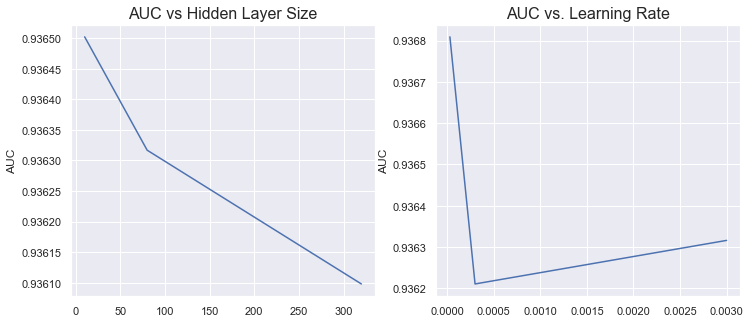

In [38]:
f, ax = plt.subplots(1,2, figsize=(12, 5))
sns.lineplot(x='Hidden Layer Size', y='AUC', data=pd.DataFrame({'Hidden Layer Size':hs, 'AUC':aucs0}), ax=ax[0])
ax[0].set_title("AUC vs Hidden Layer Size", fontsize=16)
ax[0].set(xlabel='', ylabel='AUC')

sns.lineplot(x='Learning Rate', y='AUC', data=pd.DataFrame({'Learning Rate':lrs, 'AUC':aucs1}), ax=ax[1])
ax[1].set_title("AUC vs. Learning Rate", fontsize=16)
ax[1].set(xlabel='', ylabel='AUC')

In [43]:
def trainTooLong(h):
    n_folds = 5
    n_loops = 5
    skf = StratifiedKFold(n_splits=n_folds)

    for train_index, test_index in skf.split(X, y):
        print("new training")
        X_tr, X_val = X[train_index], X[test_index]
        y_tr, y_val = y[train_index], y[test_index]
        data = [X_tr, X_val, y_tr, y_val]
        net, aucs = training_loop(h, 0.0003, *data, use_early_stopping=False)
        break

    epoch = [e[0] for e in aucs][:-3]
    aucs_tr = [e[1] for e in aucs]
    aucs_tr_ma = aucs_tr[0:2]
    aucs_val = [e[2] for e in aucs]
    aucs_val_ma = aucs_val[0:2]

    for i in range(2, len(aucs_tr)-3):
        aucs_tr_ma.append(sum(aucs_tr[i-2:i+3])/5)
        aucs_val_ma.append(sum(aucs_val[i-2:i+3])/5)
        
    return epoch, aucs_tr_ma, aucs_val_ma
        
epoch, aucs_tr_ma_200, aucs_val_ma_200 = trainTooLong(200)
epoch, aucs_tr_ma_2000, aucs_val_ma_2000 = trainTooLong(2000)

0it [00:00, ?it/s]

new training
# of positive examples: 3168, # of negative examples: 4344


299it [01:52,  2.66it/s]
0it [00:00, ?it/s]

new training
# of positive examples: 3168, # of negative examples: 4344


299it [05:13,  1.05s/it]


[Text(0.5, 0, 'Epochs'), Text(0, 0.5, 'AUC')]

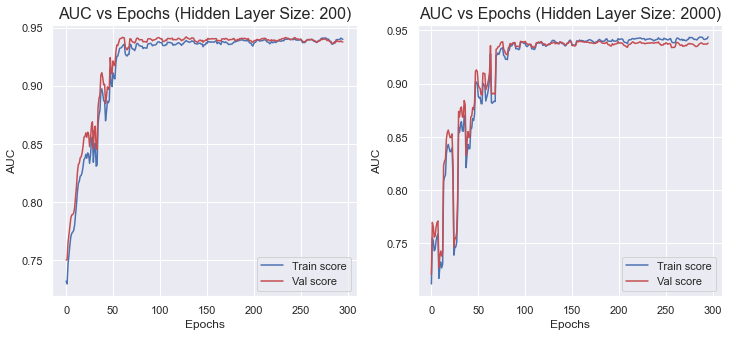

In [48]:
f, ax = plt.subplots(1,2,figsize=(12, 5))
ax[0].plot(epoch, aucs_tr_ma_200, '-', color="b", label="Train score")
ax[0].plot(epoch, aucs_val_ma_200, '-', color="r", label="Val score")
ax[0].legend()
ax[0].set_title("AUC vs Epochs (Hidden Layer Size: 200)", fontsize=16)
ax[0].set(xlabel='Epochs', ylabel='AUC')

ax[1].plot(epoch, aucs_tr_ma_2000, '-', color="b", label="Train score")
ax[1].plot(epoch, aucs_val_ma_2000, '-', color="r", label="Val score")
ax[1].legend()
ax[1].set_title("AUC vs Epochs (Hidden Layer Size: 2000)", fontsize=16)
ax[1].set(xlabel='Epochs', ylabel='AUC')

8it [00:00, 74.27it/s]

# of positive examples: 29, # of negative examples: 45


151it [00:01, 96.37it/s]
10it [00:00, 91.99it/s]

0.9898989898989898 0.8064296918799233
# of positive examples: 33, # of negative examples: 48


297it [00:03, 91.18it/s]
10it [00:00, 91.99it/s]

1.0 0.816846571518129
# of positive examples: 35, # of negative examples: 54


299it [00:03, 86.26it/s]
8it [00:00, 77.13it/s]

0.9985754985754987 0.8247211945666447
# of positive examples: 36, # of negative examples: 62


299it [00:03, 85.39it/s]
9it [00:00, 82.04it/s]

1.0 0.8068316722647433
# of positive examples: 48, # of negative examples: 60


299it [00:03, 85.24it/s]
9it [00:00, 88.47it/s]

0.9865079365079366 0.839200312182893
# of positive examples: 54, # of negative examples: 64


299it [00:03, 78.54it/s]
7it [00:00, 64.39it/s]

0.999375 0.8389415727151831
# of positive examples: 54, # of negative examples: 75


201it [00:02, 71.21it/s]
8it [00:00, 71.62it/s]

0.9375757575757576 0.7912241928959255
# of positive examples: 61, # of negative examples: 81


78it [00:01, 66.70it/s]
7it [00:00, 66.21it/s]

0.8950617283950617 0.8047932322417368
# of positive examples: 64, # of negative examples: 92


273it [00:04, 63.35it/s]
6it [00:00, 57.85it/s]

1.0 0.856839819078886
# of positive examples: 74, # of negative examples: 96


299it [00:05, 57.64it/s]
6it [00:00, 56.76it/s]

0.998046875 0.8359230263157895
# of positive examples: 85, # of negative examples: 101


299it [00:05, 55.65it/s]
5it [00:00, 48.21it/s]

0.9956841838029956 0.8671001267412731
# of positive examples: 89, # of negative examples: 116


191it [00:03, 48.18it/s]
5it [00:00, 46.20it/s]

0.9918330308529946 0.8673792845886886
# of positive examples: 84, # of negative examples: 141


275it [00:05, 47.53it/s]
5it [00:00, 44.76it/s]

0.9997467071935157 0.8656009153515684
# of positive examples: 104, # of negative examples: 142


267it [00:05, 45.86it/s]
4it [00:00, 37.84it/s]

0.9955781198820832 0.8985736715878831
# of positive examples: 119, # of negative examples: 151


209it [00:05, 40.52it/s]
4it [00:00, 39.32it/s]

0.9938869077941926 0.8732934280068818
# of positive examples: 124, # of negative examples: 172


210it [00:05, 37.18it/s]
4it [00:00, 31.09it/s]

0.9903488372093023 0.8969328667743739
# of positive examples: 137, # of negative examples: 188


207it [00:06, 34.18it/s]
4it [00:00, 32.34it/s]

0.9917363221884499 0.8869497032750225
# of positive examples: 151, # of negative examples: 205


164it [00:04, 33.20it/s]
3it [00:00, 29.92it/s]

0.9952793076317861 0.8990797218609541
# of positive examples: 162, # of negative examples: 228


185it [00:06, 30.81it/s]
3it [00:00, 29.20it/s]

0.9875168690958165 0.884483835926062
# of positive examples: 177, # of negative examples: 251


132it [00:04, 28.75it/s]
3it [00:00, 27.60it/s]

0.97057484348321 0.8992549309795647
# of positive examples: 198, # of negative examples: 271


167it [00:06, 24.71it/s]
3it [00:00, 23.32it/s]

0.9866520887431097 0.9218273753331017
# of positive examples: 234, # of negative examples: 279


164it [00:07, 22.41it/s]
2it [00:00, 19.66it/s]

0.9773111516872929 0.9119020060761845
# of positive examples: 253, # of negative examples: 309


144it [00:06, 22.00it/s]
3it [00:00, 22.28it/s]

0.9798951799982816 0.9143086922511996
# of positive examples: 253, # of negative examples: 364


112it [00:05, 21.37it/s]
2it [00:00, 16.85it/s]

0.977022977022977 0.9128891323166455
# of positive examples: 280, # of negative examples: 397


112it [00:05, 18.88it/s]
2it [00:00, 16.71it/s]

0.9744026142011029 0.9221793857238944
# of positive examples: 321, # of negative examples: 420


116it [00:07, 16.25it/s]
2it [00:00, 14.97it/s]

0.9768732492997199 0.9237424524064417
# of positive examples: 340, # of negative examples: 473


98it [00:06, 15.99it/s]
2it [00:00, 16.99it/s]

0.9710343976173208 0.9277601596774029
# of positive examples: 370, # of negative examples: 520


99it [00:06, 15.03it/s]
2it [00:00, 14.64it/s]

0.9736486486486486 0.9270307500561502
# of positive examples: 400, # of negative examples: 576


88it [00:05, 14.86it/s]
2it [00:00, 14.07it/s]

0.9716991631054132 0.926500949250384
# of positive examples: 447, # of negative examples: 623


78it [00:05, 14.19it/s]
2it [00:00, 12.69it/s]

0.967326556090601 0.9266634836877196
# of positive examples: 498, # of negative examples: 675


60it [00:04, 12.49it/s]
0it [00:00, ?it/s]

0.9669232158988257 0.9308777567599439
# of positive examples: 523, # of negative examples: 762


93it [00:08, 10.74it/s]
1it [00:00,  9.12it/s]

0.9698877368051766 0.9305145465800063
# of positive examples: 587, # of negative examples: 822


78it [00:07,  9.92it/s]
1it [00:00,  9.28it/s]

0.9591862090386706 0.9283305058835307
# of positive examples: 618, # of negative examples: 926


55it [00:05,  9.42it/s]
1it [00:00,  8.64it/s]

0.9614908393535414 0.9301784671837211
# of positive examples: 691, # of negative examples: 1002


54it [00:06,  8.22it/s]
1it [00:00,  8.36it/s]

0.9567544016444723 0.9324648944625982
# of positive examples: 768, # of negative examples: 1088


41it [00:05,  7.56it/s]
1it [00:00,  6.77it/s]

0.9445385061919506 0.935288980111472
# of positive examples: 848, # of negative examples: 1185


48it [00:07,  6.46it/s]
1it [00:00,  5.86it/s]

0.9539451476793248 0.9336338715938047
# of positive examples: 958, # of negative examples: 1271


46it [00:07,  6.41it/s]
0it [00:00, ?it/s]

0.952475224213267 0.9325824752123981
# of positive examples: 1038, # of negative examples: 1404


47it [00:08,  5.56it/s]
0it [00:00, ?it/s]

0.9473550203690391 0.9372183816917117
# of positive examples: 1137, # of negative examples: 1540


48it [00:09,  5.05it/s]
0it [00:00, ?it/s]

0.9536803474303472 0.9345805620698936
# of positive examples: 1231, # of negative examples: 1703


42it [00:08,  4.69it/s]
0it [00:00, ?it/s]

0.9520353875867533 0.9353652417932065
# of positive examples: 1352, # of negative examples: 1864


39it [00:08,  4.58it/s]
0it [00:00, ?it/s]

0.9475497125716614 0.9390852659523204
# of positive examples: 1504, # of negative examples: 2020


33it [00:08,  4.06it/s]
0it [00:00, ?it/s]

0.9548404399027383 0.9297294096518194
# of positive examples: 1627, # of negative examples: 2235


27it [00:07,  3.68it/s]
0it [00:00, ?it/s]

0.9477659049588731 0.9367882121687721
# of positive examples: 1767, # of negative examples: 2466


40it [00:11,  3.34it/s]
0it [00:00, ?it/s]

0.9483425932598717 0.9419258095380864
# of positive examples: 1936, # of negative examples: 2704


26it [00:08,  3.11it/s]
0it [00:00, ?it/s]

0.9461372136735191 0.9381259833454852
# of positive examples: 2138, # of negative examples: 2947


33it [00:11,  2.83it/s]
0it [00:00, ?it/s]

0.953176631837589 0.9292183681344596
# of positive examples: 2337, # of negative examples: 3236


22it [00:08,  2.56it/s]
0it [00:00, ?it/s]

0.9480400250885168 0.9336201777268776
# of positive examples: 2563, # of negative examples: 3545


28it [00:12,  2.27it/s]
0it [00:00, ?it/s]

0.9471013881098508 0.9381479130776439
# of positive examples: 2809, # of negative examples: 3885


24it [00:11,  2.13it/s]


0.9445259394203056 0.9453668123551671


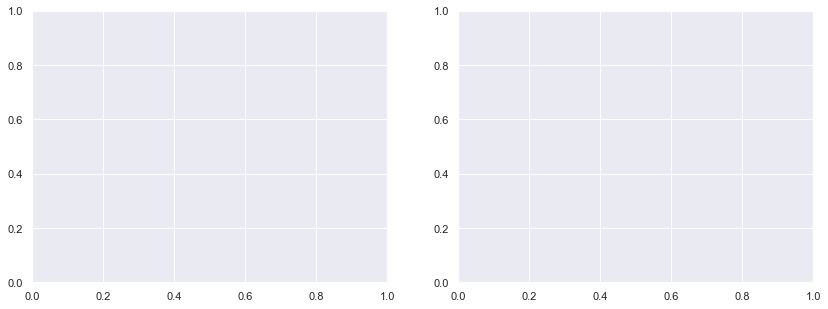

In [50]:
train_szs = np.logspace(-2, -0.05, 50) #np.linspace(0.01, 0.9, 50)
n = 1
scores_tr = []
scores_val = []
for train_sz in train_szs:
    avg_score_tr = 0
    avg_score_val = 0
    worked = 0
    for i in range(n):
        X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train, test_size=1-train_sz)
        data = [X_train1, X_test1, y_train1, y_test1]
        if (y_train1.sum()==0) or (y_test1.sum()==0) or ((y_train1==0).sum()==0) or ((y_test1==0).sum()==0): continue
            
        net, aucs = training_loop(50, 0.0003, *data, use_early_stopping=True)
        auc, acc = evaluate(net, X_test=X_test1, y_test=y_test1)
        avg_score_val += auc
        auc, acc = evaluate(net, X_test=X_train1, y_test=y_train1)
        avg_score_tr += auc
        worked += 1
    avg_score_tr /= worked
    avg_score_val /= worked
    scores_tr.append(avg_score_tr)
    print(avg_score_tr, avg_score_val)
    scores_val.append(avg_score_val)

f, ax = plt.subplots(1,2, figsize=(14, 5))


[Text(0.5, 0, 'Log2(Dataset Size)'), Text(0, 0.5, 'AUC')]

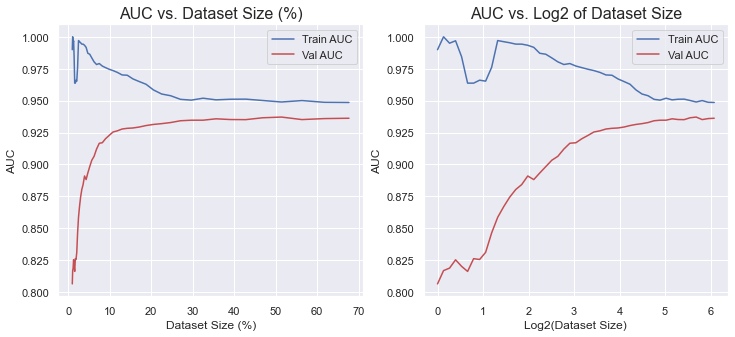

In [53]:
def compute_moving_averages(x, y1, y2):
    x_ma = x[:-3]
    y1_ma = y1[0:2]
    y2_ma = y2[0:2]
    for i in range(2, len(x)-3):
        y1_ma.append(sum(y1[i-2:i+3])/5)
        y2_ma.append(sum(y2[i-2:i+3])/5)
    return x_ma, y1_ma, y2_ma

train_szs_ma, aucs_tr_ma, aucs_val_ma = compute_moving_averages(train_szs, scores_tr, scores_val)

f, ax = plt.subplots(figsize=(6, 5))
ax.plot(np.array(train_szs_ma)*100, aucs_tr_ma, '-', color="b", label="Train AUC")
ax.plot(np.array(train_szs_ma)*100, aucs_val_ma, '-', color="r", label="Val AUC")
ax.legend()
ax.set_title("AUC vs. Dataset Size (%)", fontsize=16)
ax.set(xlabel='Dataset Size (%)', ylabel='AUC')

In [95]:
# Finding final train and test scores
data = [X_train, X_test, y_train, y_test]
net, aucs = training_loop(50, 0.0003, *data, use_early_stopping=True)

0it [00:00, ?it/s]

# of positive examples: 3178, # of negative examples: 4334


12it [00:11,  1.03it/s]


In [96]:
net = net.eval()
trn_auc, acc = evaluate(net, X_test=X_train, y_test=y_train)
tst_auc, acc = evaluate(net, X_test=X_test, y_test=y_test)
print("Train: ", trn_auc)
print("Test: ", tst_auc)

Train:  0.9421302935643037
Test:  0.9353247785335297


In [57]:
aucs

[[0, 0.8350379189799946, 0.6525711236554611],
 [1, 0.89185921297146, 0.6461341870980425],
 [2, 0.9212740246742223, 0.6365784817592045],
 [3, 0.9353644136574285, 0.6304055382368635],
 [4, 0.941082909860512, 0.6252057179768024],
 [5, 0.9427295428214187, 0.6240570674305614],
 [6, 0.9435727543991465, 0.6218299772516641],
 [7, 0.9446516601472881, 0.6187041873788861],
 [8, 0.9453700344704965, 0.6161513185609572],
 [9, 0.9460367890818575, 0.615714606678462],
 [10, 0.9464855041811966, 0.6097902097902097],
 [11, 0.9472331834449849, 0.6073833796725362],
 [12, 0.9476910395349637, 0.6072963181396916],
 [13, 0.9482126137067541, 0.6072289156626506],
 [14, 0.9487156370445995, 0.6058331227005925],
 [15, 0.9488145748256401, 0.6020333080574045],
 [16, 0.9493732506653206, 0.5992585727525487],
 [17, 0.9499380204987612, 0.597861375572219],
 [18, 0.9500134784803157, 0.5964894543207796],
 [19, 0.9504481236234745, 0.5937259527620974],
 [20, 0.9505431182320822, 0.592007189597551],
 [21, 0.9510634377580985, 0.5

### 1.3 Boosting

In [78]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(X_tr.shape)

(4507, 46)


In [79]:
from sklearn import ensemble
from sklearn import datasets

n_folds = 5
n_loops = 3
n_estimators2 = range(1, 200, 5)
skf = StratifiedKFold(n_splits=n_folds)
avg_auc_trs_2 = []
avg_auc_vals_2 = []

for n in tqdm(n_estimators2):
    avg_auc_tr = 0
    avg_auc_val = 0
    for i in range(n_loops):
        for train_index, test_index in skf.split(X_train, y_train):
            X_tr, X_val = X[train_index], X[test_index]
            y_tr, y_val = y[train_index], y[test_index]
            
            original_params = {'n_estimators': n, 'max_depth': 2, 'random_state': 2,
                           'loss': 'exponential'}
            params = dict(original_params)
            clf = ensemble.GradientBoostingClassifier(**params)
            clf.fit(X_tr, y_tr)
            y_pred_tr = clf.predict(X_tr)
            y_pred_val = clf.predict(X_val)
            avg_auc_tr += roc_auc_score(y_tr, y_pred_tr)
            avg_auc_val += roc_auc_score(y_val, y_pred_val)
    avg_auc_tr /= (n_loops*n_folds)
    avg_auc_val /= (n_loops*n_folds)
    avg_auc_trs_2.append(avg_auc_tr)
    avg_auc_vals_2.append(avg_auc_val)

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [08:53<00:00, 13.34s/it]


In [80]:
n_estimators4 = range(1, 100, 5)
skf = StratifiedKFold(n_splits=n_folds)
avg_auc_trs_4 = []
avg_auc_vals_4 = []

for n in tqdm(n_estimators4):
    avg_auc_tr = 0
    avg_auc_val = 0
    for i in range(n_loops):
        for train_index, test_index in skf.split(X_train, y_train):
            X_tr, X_val = X[train_index], X[test_index]
            y_tr, y_val = y[train_index], y[test_index]
            
            original_params = {'n_estimators': n, 'max_depth': 4, 'random_state': 2,
                           'loss': 'exponential'}
            params = dict(original_params)
            clf = ensemble.GradientBoostingClassifier(**params)
            clf.fit(X_tr, y_tr)
            y_pred_tr = clf.predict(X_tr)
            y_pred_val = clf.predict(X_val)
            avg_auc_tr += roc_auc_score(y_tr, y_pred_tr)
            avg_auc_val += roc_auc_score(y_val, y_pred_val)
    avg_auc_tr /= (n_loops*n_folds)
    avg_auc_val /= (n_loops*n_folds)
    avg_auc_trs_4.append(avg_auc_tr)
    avg_auc_vals_4.append(avg_auc_val)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [03:58<00:00, 11.94s/it]


[Text(0.5, 0, 'Boosting Iterations'), Text(0, 0.5, 'AUC')]

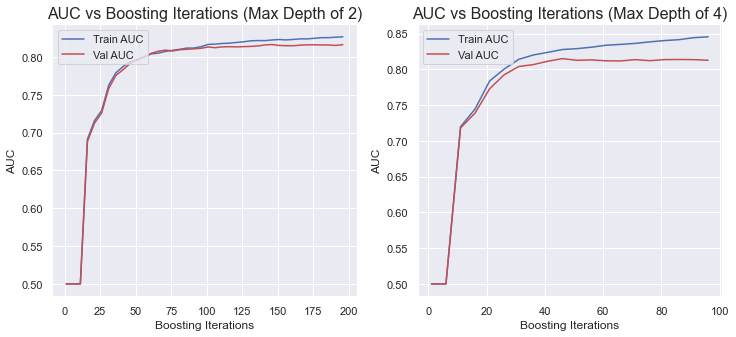

In [81]:
f, ax = plt.subplots(1,2,figsize=(12, 5))
ax[0].plot(n_estimators2, avg_auc_trs_2,'-',color="b", label="Train AUC")
ax[0].plot(n_estimators2, avg_auc_vals_2,'-',color="r", label="Val AUC")
ax[0].legend(loc='upper left')
ax[0].set_title("AUC vs Boosting Iterations (Max Depth of 2)", fontsize=16)
ax[0].set(xlabel='Boosting Iterations', ylabel='AUC')

ax[1].plot(n_estimators4, avg_auc_trs_4,'-',color="b", label="Train AUC")
ax[1].plot(n_estimators4, avg_auc_vals_4,'-',color="r", label="Val AUC")
ax[1].legend(loc='upper left')
ax[1].set_title("AUC vs Boosting Iterations (Max Depth of 4)", fontsize=16)
ax[1].set(xlabel='Boosting Iterations', ylabel='AUC')

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.50it/s]


[Text(0.5, 0, 'Dataset Size (%)'), Text(0, 0.5, 'AUC')]

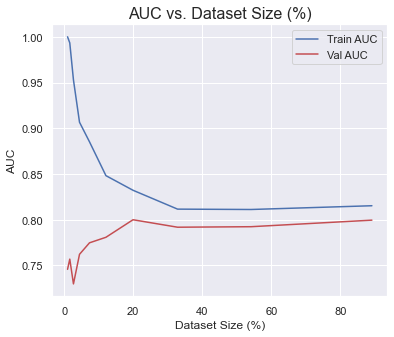

In [88]:
train_szs = np.logspace(-2, -0.05, 10) #np.linspace(0.01, 0.9, 50)
n = 3
scores_tr = []
scores_val = []
for train_sz in tqdm(train_szs):
    avg_score_tr = 0
    avg_score_val = 0
    worked = 0
    for i in range(n):
        X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train, test_size=1-train_sz)
        data = [X_train1, X_test1, y_train1, y_test1]
        if (y_train1.sum()==0) or (y_test1.sum()==0) or ((y_train1==0).sum()==0) or ((y_test1==0).sum()==0): continue
            
        original_params = {'n_estimators': 100, 'max_depth': 2, 'random_state': 2,
                       'loss': 'exponential'}
        params = dict(original_params)
        clf = ensemble.GradientBoostingClassifier(**params)
        clf.fit(X_train1, y_train1)
        
        y_pred_tr = clf.predict(X_train1)
        y_pred_val = clf.predict(X_test1)
        avg_score_val += roc_auc_score(y_test1, y_pred_val)
        avg_score_tr += roc_auc_score(y_train1, y_pred_tr)
        
        worked += 1
    avg_score_tr /= worked
    avg_score_val /= worked
    scores_tr.append(avg_score_tr)
    scores_val.append(avg_score_val)

# train_szs_ma, aucs_tr_ma, aucs_val_ma = compute_moving_averages(train_szs, scores_tr, scores_val)

f, ax = plt.subplots(figsize=(6, 5))
ax.plot(np.array(train_szs)*100, scores_tr, '-', color="b", label="Train AUC")
ax.plot(np.array(train_szs)*100, scores_val, '-', color="r", label="Val AUC")
ax.legend()
ax.set_title("AUC vs. Dataset Size (%)", fontsize=16)
ax.set(xlabel='Dataset Size (%)', ylabel='AUC')

In [109]:
# Finding final train and test scores
from time import time
tic = time()
clf = ensemble.GradientBoostingClassifier(n_estimators= 100,max_depth=2, random_state=2,loss='exponential')
clf.fit(X_train, y_train)
print("Time was {}".format(time()-tic))
y_pred_tr = clf.predict(X_train)
y_pred_val = clf.predict(X_test)
print("Test: ", roc_auc_score(y_test, y_pred_val))
print("Train: ", roc_auc_score(y_train, y_pred_tr))

Time was 0.8028788566589355
Test:  0.8165422013416544
Train:  0.8079274786127578


### 1.4 Support Vector Machines

#### Deciding on a kernel..

In [103]:
from sklearn import svm
n_folds = 10
skf = StratifiedKFold(n_splits=n_folds)


for kernel in ['rbf', 'poly', 'sigmoid']:
    auc_avg = 0
    for train_index, test_index in skf.split(X_train, y_train):
        X_tr, X_val = X[train_index], X[test_index]
        y_tr, y_val = y[train_index], y[test_index]
        clf = svm.SVC(kernel=kernel, class_weight={0:1, 1:5})
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_val)
        auc = roc_auc_score(y_val, np.round(y_pred).astype(np.int32))
        auc_avg += auc
#         print("Kernel: {}, Score: {}".format(kernel, auc)) 
    auc_avg /= n_folds
    print("Kernel: {}, Score: {}".format(kernel, auc_avg)) 


Kernel: rbf, Score: 0.5939047028073106
Kernel: poly, Score: 0.573448696801162
Kernel: sigmoid, Score: 0.5758684599807056


In [104]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from matplotlib.colors import Normalize
from math import log10, floor

# Utility function to move the midpoint of a colormap to be around
# the values of interest.
class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

# Comparing different values of C and gamma
# https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html#sphx-glr-auto-examples-svm-plot-rbf-parameters-py
# metric options: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

def round_sig(x, sig=2):
    return round(x, sig-int(floor(log10(abs(x))))-1)

C_range = [round_sig(el) for el in np.logspace(-9, 5, 8)]
gamma_range = [round_sig(el) for el in np.logspace(-12, 2, 8)]
print(C_range, gamma_range)
# C_range = [1]
# gamma_range = [0.01]
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=43)
grid = GridSearchCV(svm.SVC(kernel='rbf', class_weight={0:1, 1:5}), param_grid=param_grid, cv=cv, scoring='roc_auc')
grid.fit(X_train, y_train)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))
grid.cv_results_['mean_test_score']

[1e-09, 1e-07, 1e-05, 0.001, 0.1, 10.0, 1000.0, 100000.0] [1e-12, 1e-10, 1e-08, 1e-06, 0.0001, 0.01, 1.0, 100.0]
The best parameters are {'C': 100000.0, 'gamma': 1e-06} with a score of 0.93


array([0.75708278, 0.8043887 , 0.82367048, 0.8238324 , 0.82392334,
       0.82824417, 0.808871  , 0.72931905, 0.80436829, 0.8043887 ,
       0.8234815 , 0.82383906, 0.82391181, 0.82824062, 0.80972629,
       0.72840742, 0.80438781, 0.80438825, 0.82335818, 0.82385503,
       0.82392689, 0.82967971, 0.81011978, 0.73292343, 0.80438648,
       0.80438825, 0.82351078, 0.82386656, 0.8264209 , 0.83313725,
       0.81064502, 0.73659569, 0.80438825, 0.80438825, 0.82347707,
       0.82634549, 0.8281164 , 0.92571112, 0.81087659, 0.73784225,
       0.80439091, 0.80438825, 0.82574838, 0.82798687, 0.92765149,
       0.90463224, 0.79826457, 0.72680064, 0.80438559, 0.80438825,
       0.82795227, 0.92864431, 0.92398811, 0.88478041, 0.77711383,
       0.71262798, 0.80438737, 0.80438825, 0.9337876 , 0.93486204,
       0.91187117, 0.87939668, 0.76132198, 0.70911499])

In [115]:
scores = grid.cv_results_['mean_test_score'].reshape(len(C_range),
                                                     len(gamma_range))
print(scores)

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.copper,
           norm=MidpointNormalize(vmin=0.45, midpoint=0.65))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Validation AUC')
plt.show()

ValueError: cannot reshape array of size 12 into shape (8,8)

In [ ]:
train_szs = np.logspace(-2, -0.05, 50) #np.linspace(0.01, 0.9, 50)
print(train_szs)
n = 10
scores_tr = []
scores_val = []
for train_sz in train_szs:
    avg_score_tr = 0
    avg_score_val = 0
    worked = 0
    for i in range(n):
        X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train, test_size=1-train_sz)
        print(y_train1.sum(),y_test1.sum())
        if (y_train1.sum()==0) or (y_test1.sum()==0) or ((y_train1==0).sum()==0) or ((y_test1==0).sum()==0): continue
            
        clf = svm.SVC(kernel='rbf', C=100000, gamma=1e-8, class_weight={0:1, 1:5})
        clf.fit(X_train1, y_train1)
        
        y_pred_tr = clf.predict(X_train1)
        y_pred_val = clf.predict(X_test1)
        avg_score_val += roc_auc_score(y_test1, y_pred_val)
        avg_score_tr += roc_auc_score(y_train1, y_pred_tr)
        
        worked += 1
    avg_score_tr /= worked
    avg_score_val /= worked
    scores_tr.append(avg_score_tr)
#     print(avg_score_tr, avg_score_val)
    scores_val.append(avg_score_val)
print(scores_val)

train_szs_ma, aucs_tr_ma, aucs_val_ma = compute_moving_averages(train_szs, scores_tr, scores_val)

[Text(0.5, 0, 'Dataset Size (%)'), Text(0, 0.5, 'AUC')]

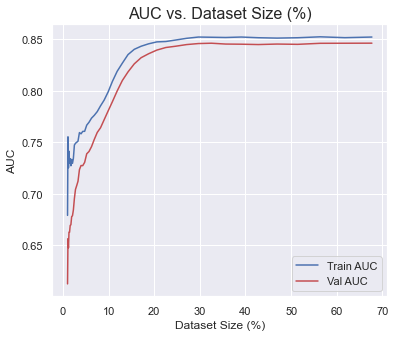

In [108]:
f, ax = plt.subplots(figsize=(6, 5))
ax.plot(np.array(train_szs_ma)*100, aucs_tr_ma, '-', color="b", label="Train AUC")
ax.plot(np.array(train_szs_ma)*100, aucs_val_ma, '-', color="r", label="Val AUC")
ax.legend()
ax.set_title("AUC vs. Dataset Size (%)", fontsize=16)
ax.set(xlabel='Dataset Size (%)', ylabel='AUC')

In [107]:
# Finding final train and test scores
from time import time
tic = time()
clf = svm.SVC(kernel='rbf', C=100000, gamma=1e-6)
clf.fit(X_train, y_train)
print("Time was {}".format(time()-tic))
y_pred_tr = clf.predict(X_train)
y_pred_val = clf.predict(X_test)
print("Test: ", roc_auc_score(y_test, y_pred_val))
print("Train: ", roc_auc_score(y_train, y_pred_tr))

Time was 1.4640851020812988
Test:  0.7908573498819624
Train:  0.7810801888466864


### 1.5 K Nearest Neighbors

In [111]:
import sklearn
def round_sig(x, sig=2):
    return round(x, sig-int(floor(log10(abs(x))))-1)

p_range = [1,2,3]
k_range = [10,20,40,80]
param_grid = dict(n_neighbors=k_range, p=p_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=43)
grid = GridSearchCV(sklearn.neighbors.KNeighborsClassifier(), param_grid=param_grid, cv=cv, scoring='roc_auc')
grid.fit(X_train, y_train)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))
grid.cv_results_['mean_test_score']

The best parameters are {'n_neighbors': 20, 'p': 3} with a score of 0.85


array([0.83516103, 0.83766613, 0.84668929, 0.84101233, 0.84339988,
       0.85002795, 0.8376302 , 0.84213158, 0.84960163, 0.83329385,
       0.83742303, 0.8426546 ])

[[0.83516103 0.84101233 0.8376302  0.83329385]
 [0.83766613 0.84339988 0.84213158 0.83742303]
 [0.84668929 0.85002795 0.84960163 0.8426546 ]]


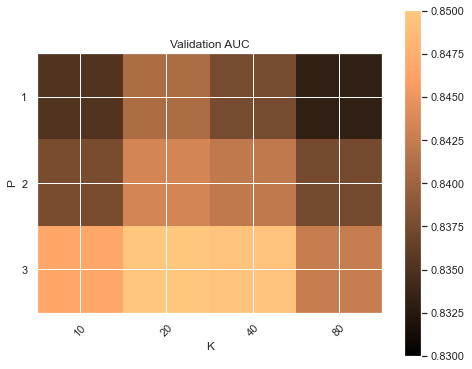

In [114]:
scores = grid.cv_results_['mean_test_score'].reshape(len(k_range),
                                                     len(p_range))
scores = np.transpose(scores)
print(scores)

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.copper,
           norm=MidpointNormalize(vmin=0.83, midpoint=0.84))
plt.xlabel('K')
plt.ylabel('P')
plt.colorbar()
plt.xticks(np.arange(len(k_range)), k_range, rotation=45)
plt.yticks(np.arange(len(p_range)), p_range)
plt.title('Validation AUC')
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.12s/it]


ValueError: x and y must have same first dimension, but have shapes (0,) and (1,)

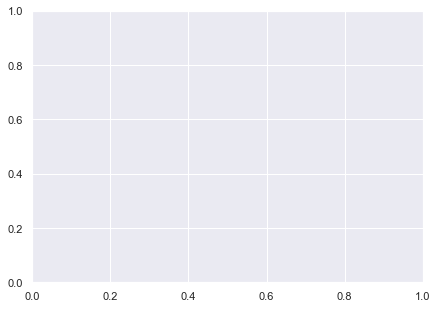

In [121]:
train_szs = np.logspace(-1, -0.05, 50) #np.linspace(0.01, 0.9, 50)
n = 3
scores_tr = []
scores_val = []
for train_sz in tqdm(train_szs):
    avg_score_tr = 0
    avg_score_val = 0
    worked = 0
    for i in range(n):
        X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train, test_size=1-train_sz)
        if (y_train1.sum()==0) or (y_test1.sum()==0) or ((y_train1==0).sum()==0) or ((y_test1==0).sum()==0): continue
            
        clf = sklearn.neighbors.KNeighborsClassifier(p=3, n_neighbors=20)
        clf.fit(X_train1, y_train1)
        
        y_pred_tr = clf.predict(X_train1)
        y_pred_val = clf.predict(X_test1)
        avg_score_val += roc_auc_score(y_test1, y_pred_val)
        avg_score_tr += roc_auc_score(y_train1, y_pred_tr)
        
        worked += 1
    avg_score_tr /= worked
    avg_score_val /= worked
    scores_tr.append(avg_score_tr)
    scores_val.append(avg_score_val)

train_szs_ma, aucs_tr_ma, aucs_val_ma = compute_moving_averages(train_szs, scores_tr, scores_val)

f, ax = plt.subplots(1,1,figsize=(7, 5))
ax.plot(np.array(train_szs_ma)*100, aucs_tr_ma, '-', color="b", label="Train AUC")
ax.plot(np.array(train_szs_ma)*100, aucs_val_ma, '-', color="r", label="Val AUC")
ax.legend()
ax.set_title("AUC vs. Dataset Size (%)", fontsize=16)
ax.set(xlabel='Dataset Size (%)', ylabel='AUC')


In [122]:
# Finding final train and test scores
from time import time
tic = time()
clf = sklearn.neighbors.KNeighborsClassifier(p=3, n_neighbors=20)
clf.fit(X_train, y_train)
print("Time was {}".format(time()-tic))
y_pred_tr = clf.predict(X_train)
y_pred_val = clf.predict(X_test)
print("Test: ", roc_auc_score(y_test, y_pred_val))
print("Train: ", roc_auc_score(y_train, y_pred_tr))

Time was 0.08078312873840332
Test:  0.7427950354112615
Train:  0.7410808987966349


### Notes on Office Hours #1:

1. F1 - No details given on assignment on purpose
2. F2 - Exams are closed book
3. F3 - Target concept - function to learn
4. F5 - Choosing dataset - 2 different datasets
    - overfit/underfit
    - noisy or not
    - categorical or numeric
5. Different kernels in SVM - 
6. DTs vs. NN - why do things happen, reveal the differences between algos
7. Analysis of performance as a function of dataset size
    - do this with training and validation data
    - Learning curve analysis with fixed hyperparameters
    Grid search first --> Learning Curve analysis (bias/variance) --> solution for it
    - next do model complexity analysis, this could be n parameters or something else (if too much variance - change hyperparameter) --> perform. on training data/valid?
    - Less variance? Good! They expect us to show our thought process. 
    - Use cross validation
    - Talk about bias/variance tradeoff
    - Human error equation - https://towardsdatascience.com/regularization-the-path-to-bias-variance-trade-off-b7a7088b4577
8. F12 - Stick with classification
9. Make sure to isolate hyperparameters.
10. If anything has a much longer wall clock - could be interesting